In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_lib import loadmat
from matlab.matlab_yaro_lib import matstruct2dict, merge_dicts, read_lick, read_paw, read_whisk
from qt_wrapper import gui_fname, gui_fpath
from signal_lib import trunc_idx, resample

Appended library directory /home/alyosha/work/nest-mesoscopic-metric-test/codes/lib


In [2]:
pwd = './'#'/mnt/hifo_scratch1/Yaro/data_for_TE/'
m_file = gui_fname("Select data directory", pwd, filter="Matlab Files (*.m, *.mat)")
print(m_file)
f = loadmat(m_file)

for k,v in f.items():
    if isinstance(v, float) or isinstance(v, int) or isinstance(v, list):
        print(k, v)
    else:
        print(k, v.shape)

/home/alyosha/Downloads/tmp-behaviour-yaro/lick/mtp_10_2016_09_12_a/lick_traces.mat
top_thresh 2.65
bot_thresh 2.59
licks_go (1500, 139)
licks_nogo (1500, 124)
x (1500,)
licks_early (0,)
licks_FA (1500, 19)
licks_miss (1500, 5)
go_thresh (1500, 139)
nogo_thresh (1500, 124)
early_thresh (0,)
FA_thresh (1500, 19)
miss_thresh (1500, 5)


In [4]:
TARGET_RANGE = [0, 8] # Seconds goal
TARGET_FREQ = 20 # Hz
TARGET_NTIMES = int((TARGET_RANGE[1]-TARGET_RANGE[0])*TARGET_FREQ) + 1
TARGET_TIMES = np.linspace(TARGET_RANGE[0], TARGET_RANGE[1], TARGET_NTIMES)

# Lick

**lick_traces**
* What are the threshold definitions
  * 
* What are the definitions of 2D arrays
  * What are the dimensions (1500 x N) - (sample @ 100Hz(crop to 8s) vs iTrial)
  
**TODO**
- Yaro said some thresholds were off - how to determine good thresholds
- Gaussian broadening + cutoff from the top - get nice continuous lick signal

In [17]:
pwd = './'#'/mnt/hifo_scratch1/Yaro/data_for_TE/'
m_path = gui_fpath("Select data directory", pwd)
f = read_lick(m_path)

In [20]:
# Plot before
plt.figure()
plt.plot(f['tLicks'], f['licks_go'][:, 10])
plt.show()

param_resample = {'method' : 'averaging', 'kind' : 'kernel', 'ker_sig2' : 0.5/TARGET_FREQ}
l,r = trunc_idx(f['tLicks'], 0, 8)
f['tLicks'] = f['tLicks'][l:r]

for k in ['licks_go', 'licks_nogo', 'licks_miss', 'licks_FA', 'licks_early']:
    if len(f[k]) > 0:
        nTrials = f[k].shape[1]

        # Truncate
        f[k] = f[k][l:r]
        f[k] = np.array([resample(f['tLicks'], f[k][:, iTrial], TARGET_TIMES, param_resample) for iTrial in range(nTrials)])
        
# Plot after
plt.figure()
plt.plot(TARGET_TIMES, f['licks_go'][10])
plt.show()

# Paw

**Trials.m**: 
(iTrial vs iTime (0-6s, sometimes 7Hz (If step=64), else (>250) 30Hz) )

**TODO**
- Rescale file to [0, 1] - subtract avg over all traces, divide by max over all traces

In [33]:
pwd = './'#'/mnt/hifo_scratch1/Yaro/data_for_TE/'
m_name = gui_fname("Select data directory", pwd, filter="Matlab Files (*.m, *.mat)")
f_paw = read_paw(m_name)

In [34]:
 f_paw['trialsPaw'].shape

(287, 64)

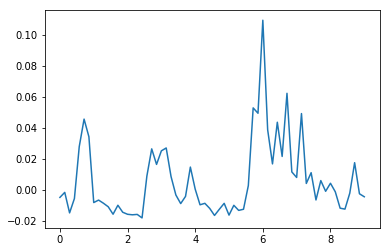

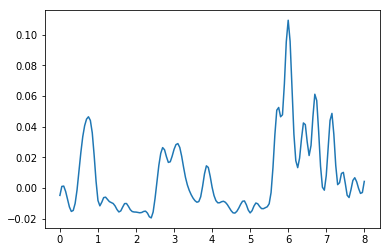

In [31]:
# Plot before
plt.figure()
plt.plot(f_paw['tPaw'], f_paw['trialsPaw'][0])
plt.show()

# 1) Subtract baseline and rescale
f_paw['trialsPaw'] -= np.meannan(f_paw['trialsPaw'])
f_paw['trialsPaw'][np.isnan(f_paw['trialsPaw'])] = 0
f_paw['trialsPaw'] /= np.max(f_paw['trialsPaw'])

# Truncate
l,r = trunc_idx(f_paw['tPaw'], 0, 8)
f_paw['tPaw'] = f_paw['tPaw'][l:r]
f_paw['trialsPaw'] = f_paw['trialsPaw'][:, l:r]

# Resample
nTrials = f_paw['trialsPaw'].shape[0]

if f_paw['freqPaw'] < TARGET_FREQ:
    param_resample = {'method' : 'interpolative', 'kind' : 'cubic'}
else
    param_resample = {'method' : 'averaging', 'kind' : 'kernel', 'ker_sig2' : 0.5/TARGET_FREQ}
f_paw['trialsPaw'] = np.array([resample(f_paw['tPaw'], f_paw['trialsPaw'][iTrial], TARGET_TIMES, param_resample) for iTrial in range(nTrials)])
        
# Plot after
plt.figure()
plt.plot(TARGET_TIMES, f_paw['trialsPaw'][0])
plt.show()

# Whisk

In [76]:
pwd = './'#'/mnt/hifo_scratch1/Yaro/data_for_TE/'
m_path = gui_fpath("Select data directory", pwd)
f_whisk = read_whisk(m_path)

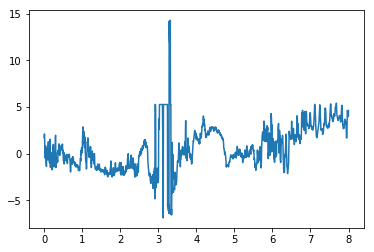

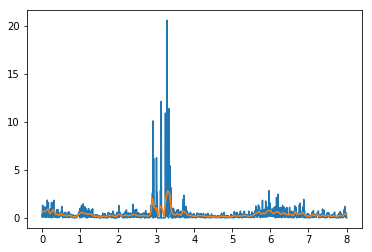

In [82]:
# Plot before
plt.figure()
plt.plot(f_whisk['tWhisk'], f_whisk['whiskAngle'][:, 0])
plt.show()

# 1) Subtract baseline
nTrials = f_whisk['whiskAngle'].shape[1]
f_whisk['whiskAngle'] -= np.nanmean(f_whisk['whiskAngle'])
f_whisk['whiskAngle'][np.isnan(f_whisk['whiskAngle'])] = 0
f_whisk['whiskAbsVelocity'] = np.vstack((np.abs(f_whisk['whiskAngle'][1:] - f_whisk['whiskAngle'][:-1]), np.zeros(nTrials)))

# Truncate
l,r = trunc_idx(f_whisk['tWhisk'], 0, 8)
f_whisk['tWhisk']     = f_whisk['tWhisk'][l:r]
f_whisk['whiskAngle'] = f_whisk['whiskAngle'][l:r]
f_whisk['whiskAbsVelocity'] = f_whisk['whiskAbsVelocity'][l:r]

# Plot after
plt.figure()
plt.plot(f_whisk['tWhisk'], f_whisk['whiskAbsVelocity'][:,0])

# Resample
param_resample = {'method' : 'averaging', 'kind' : 'kernel', 'ker_sig2' : (4/200)**2}
f_whisk['whiskAbsVelocity'] = np.array([resample(f_whisk['tWhisk'], f_whisk['whiskAbsVelocity'][:, iTrial], TARGET_TIMES, param_resample) for iTrial in range(nTrials)])
        

plt.plot(TARGET_TIMES, f_whisk['whiskAbsVelocity'][0])
plt.show()